# Abberation mapping workflow 2: Analyze zola results #

*26 Jan 2023 first refactoring*

*07 Sep 2023 updates/troubleshooting*

Originally by Debayan Saha.  Jamie White modified Debayan's notebooks. 

Updating for Jamie's environment on the cluster.

Documenting installation / file locations.

Cleaned-up version of workflow notebook.

## Load packages ##

In [1]:
import glob
import sys
sys.path.append(".")
# sys.path.append('/home/dsaha/.local/lib/python3.7/site-packages/')
from main import *
import warnings
warnings.filterwarnings(action='once')
import seaborn as sns
import pandas as pd
%load_ext autoreload
%autoreload 2
def min_max_norm(arr):
    return (arr - np.min(arr))/(np.max(arr) - np.min(arr))

In [2]:
# not needed to run notebook locally.

# %env PATH=/sw/apps/cuda/10.0.130/libnvvp:/sw/apps/cuda/10.0.130/extras/CUPTI/lib64/:/sw/apps/jupyter-tensorboard/0.1.6/bin:/sw/apps/hdf5/1.8.16/bin:/sw/apps/cuda/10.0.130/bin:/sw/bin:/usr/lib64/qt-3.3/bin:/sbin:/bin:/usr/sbin:/usr/bin
# %env LD_LIBRARY_PATH=/sw/apps/hdf5/1.8.16/lib:/sw/apps/cuda/10.0.130/lib64:/sw/apps/cuda/10.0.130/lib:/sw/lib 
# %env MODULEPATH=/sw/apps/modules/modulefiles:/usr/share/Modules/modulefiles:/etc/modulefiles:/lib/modules:/lib/modules/3.10.0-693.21.1.el7.x86_64

# Inputs

In [3]:
# the only thing that needs to be set after running notebook 1
parameter_file = "data/andrea/0p5mkBeadsDICHmirror_4_test3/Parameters.json"

## Load paramters from notebook 01

In [4]:
old_params = setup_param_file(parameter_file, load_mode=True)

unit                     = old_params.get('unit') 
abb_list                 = old_params.get('abb_list')
local                    = old_params.get('save_dir')
local_data_file_path     = old_params.get('save_dir')
lam                      = old_params.get('lam')
remote_project_base_path = old_params.get('remote_project_base_path')
image_file               =  old_params.get('image_file')
remote_data_file_path    = old_params.get("remote_data_file_path")

old_params

{'crop_shape': [40, 40, 40],
 'unit': [0.1, 0.06, 0.06],
 'abb_list': [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 'COMPUTERNAME': 'grill-mac-46.local',
 'thresh_bck': 10,
 'lam': 0.515,
 'thresh_dist': 11.3,
 'fiji_macro': 'zola_macro_cluster_params_passed.ijm',
 'remote_project_base_path': '/home/jwhite/projects/aberration_mapping/',
 'remote_fiji_path': '/home/jwhite/fiji/Fiji.app/ImageJ-linux64',
 'zola_script': 'bashscript_fiji3.sh',
 'image_file': 'data/andrea/0p5mkBeadsDICHmirror_4_test3/0p5mk.tif',
 'remote_data_file_path': '/home/jwhite/projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test3/',
 'FIJI_MACRO_PATH': '/projects/project-dsaha/insitu_psf/zola_macro_cluster_1p4.ijm',
 'save_dir': 'data/andrea/0p5mkBeadsDICHmirror_4_test3',
 'num_folders': 50}

## Construct local folder and file paths

In [5]:
# construct full path to image file and set save directory
local_img_path  = os.path.abspath(f"{image_file}")
local_img_path

'/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test3/0p5mk.tif'

In [6]:
local_base_path: str = f"{os.path.dirname(local_img_path)}/" # everything relative to the notebook directory
local_base_path

'/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test3/'

In [7]:
# file_path and save_dir variables for compatibility
local_data_file_path = f"{os.path.dirname(os.path.abspath(parameter_file))}/"
Local_save_dir  = local_data_file_path
local_data_file_path

'/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test3/'

In [8]:
local_patches_path = f'{local_data_file_path}patches_for_zola/'
local_patches_path

'/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test3/patches_for_zola/'

## Check the Fiji macro in use

In [9]:
# old_params['FIJI_MACRO_PATH']
old_params['fiji_macro']

'zola_macro_cluster_params_passed.ijm'

## Check the save directory files

In [10]:
local_save_dir = local_base_path

In [11]:
! ls "{local_save_dir}"

0p5mk.tif                    med_measurement
Parameters.json              patches_for_zola
Results.csv                  point_boxes
abb_maps                     pointlist.npy
accepted_points_in_image.png points
amplitude_distribution.png   rmswe
label_map.tif                selected_widths.npy
measurements                 selected_widths.png


## Construct remote filepaths ##

In [12]:
remote_project_base_path

'/home/jwhite/projects/aberration_mapping/'

In [13]:
remote_image_file_path = f"{remote_project_base_path}{image_file}"
remote_image_file_path

'/home/jwhite/projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test3/0p5mk.tif'

In [14]:
# remote_fiji_macro_path = f'{remote_project_base_path}{fiji_macro_dir}{fiji_macro}'
# remote_fiji_macro_path

In [15]:
# construct full path to image file and set save directory
remote_img_path  = f"{remote_project_base_path}{image_file}"
remote_img_path

'/home/jwhite/projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test3/0p5mk.tif'

In [16]:
# file_path and save_dir variables for compatibility
remote_data_file_path = os.path.dirname(remote_img_path) +'/'
remote_save_dir  = remote_data_file_path
remote_data_file_path

'/home/jwhite/projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test3/'

In [17]:
# remote_zola_script_path = f"{remote_project_base_path}{zola_script_dir}{zola_script}"
# remote_zola_script_path

In [18]:
remote_patches_path = f'{remote_data_file_path}patches_for_zola/'
remote_patches_path

'/home/jwhite/projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test3/patches_for_zola/'

## Copy the zola files from the remote after processing

In [19]:
remote_zola_raw = f"{remote_patches_path}zola_raw"
remote_zola_raw

'/home/jwhite/projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test3/patches_for_zola/zola_raw'

In [20]:
local_zola_raw = f"{local_patches_path}zola_raw"
local_zola_raw

'/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test3/patches_for_zola/zola_raw'

In [21]:
! scp -r falcon:"{remote_zola_raw}" "{local_patches_path}"

planes_12_z_25_y_1828_x_1514.json             100%  475    28.3KB/s   00:00    
planes_14_z_32_y_1588_x_1275.json             100%  462    25.0KB/s   00:00    
planes_14_z_30_y_1838_x_675.json              100%  464     4.4KB/s   00:00    
planes_10_z_30_y_1838_x_675.json              100%  465    22.1KB/s   00:00    
planes_14_z_29_y_1494_x_477.json              100%  474    18.8KB/s   00:00    
planes_12_z_35_y_1005_x_553.json              100%  467    10.8KB/s   00:00    
planes_12_z_37_y_160_x_1017.json              100%  461    12.0KB/s   00:00    
planes_10_z_36_y_922_x_252.json               100%  471    13.1KB/s   00:00    
planes_14_z_29_y_1077_x_1428.json             100%  470    19.5KB/s   00:00    
planes_14_z_35_y_1227_x_369.json              100%  472    29.0KB/s   00:00    
planes_14_z_34_y_1160_x_511.json              100%  467    23.7KB/s   00:00    
planes_14_z_32_y_701_x_1581.json              100%  475    28.6KB/s   00:00    
planes_10_z_29_y_1577_x_1141.json       

# Load zola and select the stable results

In [22]:
# from main import load_and_select_zola_files
zola_full = load_and_select_zola_files(local_save_dir, lam, headless=False, verbose = False, show_plots=False)

zola_directory: 
/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test3/patches_for_zola/

Found 210 zola files
Processing 210 files


100%|██████████| 70/70 [00:00<00:00, 29066.56it/s]

Using z_22_y_1935_x_1925 with rmswe 0.5468990587385539
z_22_y_1935_x_1925 has a maximum distance of 0.034886795909803335 between all its zola files
NOT Using z_25_y_1828_x_1514
z_25_y_1828_x_1514 has a maximum distance of 0.35690005989357726 between all its zola files
NOT Using z_26_y_1827_x_1514
z_26_y_1827_x_1514 has a maximum distance of 0.754219956596755 between all its zola files
NOT Using z_27_y_1748_x_1124
z_27_y_1748_x_1124 has a maximum distance of 0.2546970380246465 between all its zola files
Using z_28_y_1758_x_840 with rmswe 0.40010853210832703
z_28_y_1758_x_840 has a maximum distance of 0.0422444352139292 between all its zola files
Using z_29_y_1077_x_1428 with rmswe 0.15124490639847538
z_29_y_1077_x_1428 has a maximum distance of 0.011003460698352247 between all its zola files
Using z_29_y_1475_x_1106 with rmswe 0.1568558292611848
z_29_y_1475_x_1106 has a maximum distance of 0.013856803183446613 between all its zola files
Using z_29_y_1494_x_477 with rmswe 0.1603269201001

In [23]:
len(zola_full)
# zola_full

35

# Filter zola results by neighbors

In [24]:
from main import filter_files_by_med_dist_of_neighbors
print(f"Zola_files before filtering {len(zola_full)}")
med_del_keys = filter_files_by_med_dist_of_neighbors(zola_full)
print(f"Deleting {len(med_del_keys)} points because there medians values are far away from observed values")

# deleting the zola files
[zola_full.pop(x, None) for x in med_del_keys]
print(f"Final number of zola_files after filtering {len(zola_full)}")

Zola_files before filtering 35
Deleting 0 points because there medians values are far away from observed values
Final number of zola_files after filtering 35


In [25]:
# plane_num = 10
# crops = {key: tifffile.imread(f"{os.path.dirname(local_data_file_path)}/patches_for_zola/patches*/planes_{plane_num}_{key}.tif") for key in zola_full.keys()}
# print(len(zola_full), len(crops))

plane_num = 10

# Define the base directory for your patches
base_dir = os.path.join(os.path.dirname(local_data_file_path), "patches_for_zola")

# Find all matching tif files
crops = {}
for key in zola_full.keys():
    pattern = os.path.join(base_dir, f"patches*/planes_{plane_num}_{key}.tif")
    matching_files = glob.glob(pattern)
    for file_path in matching_files:
        try:
            # Assuming the last matching file or an arbitrary one is okay to read if there are several
            crops[key] = tifffile.imread(file_path)
        except Exception as e:
            print(f"An error occurred while reading {file_path}: {e}")

print(len(zola_full), len(crops))

35 17


# Load corresponding crops

# Show the accepted crops

z_29_y_1077_x_1428 152.0


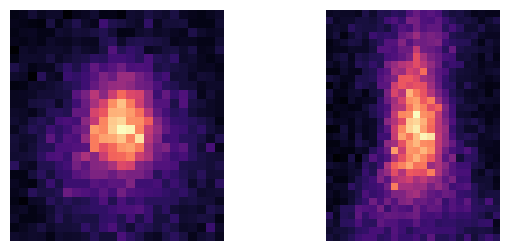

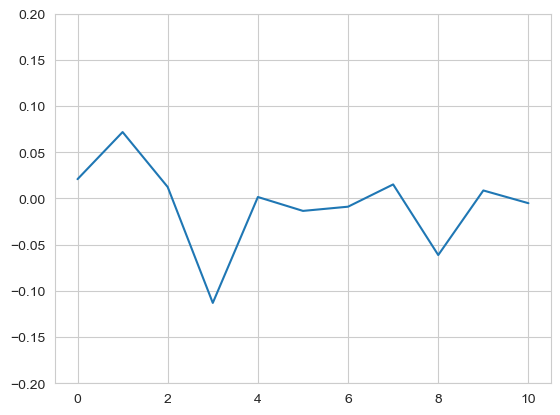

z_29_y_1475_x_1106 177.0


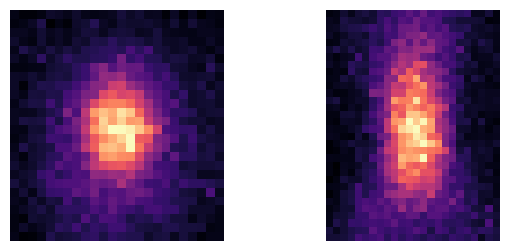

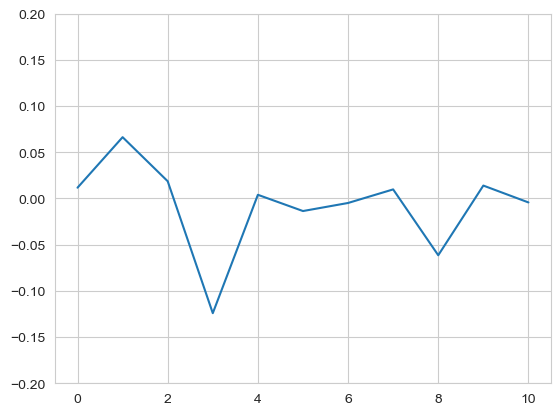

z_29_y_1494_x_477 145.0


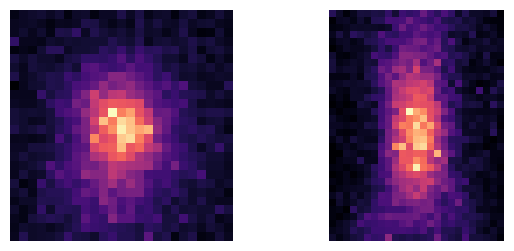

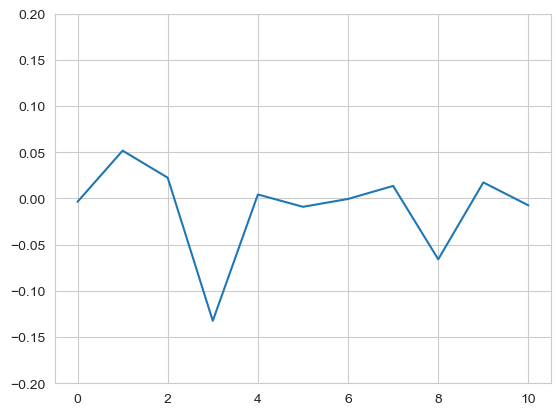

z_29_y_1746_x_1181 169.0


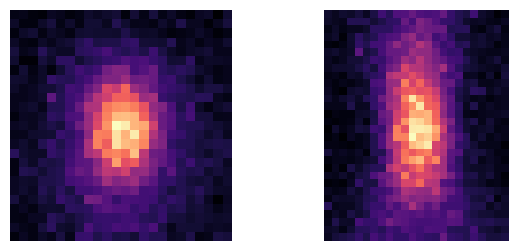

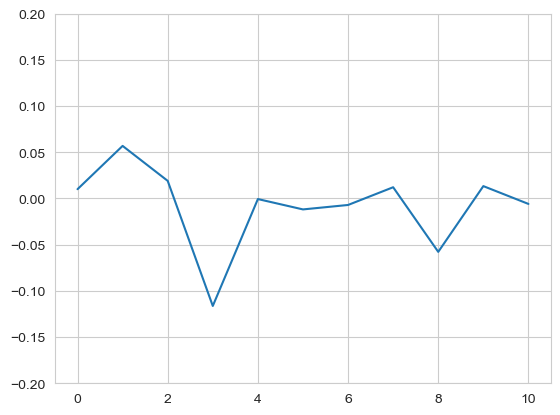

z_29_y_835_x_1517 168.0


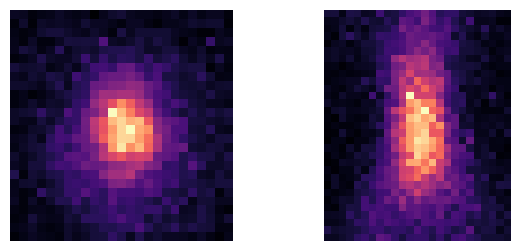

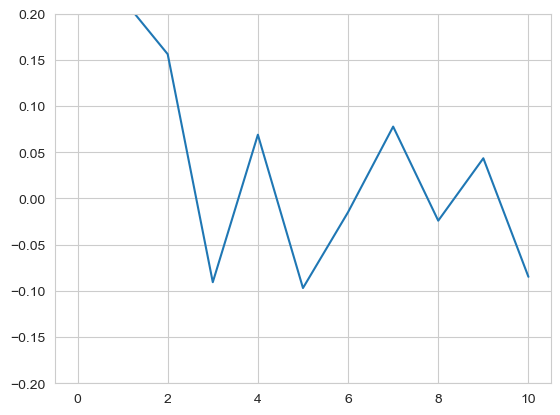

z_30_y_1838_x_675 142.0


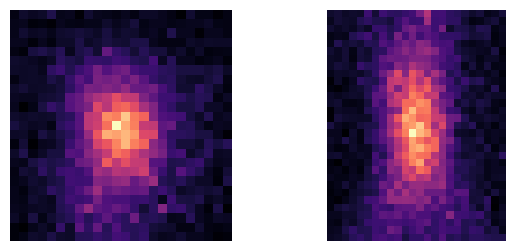

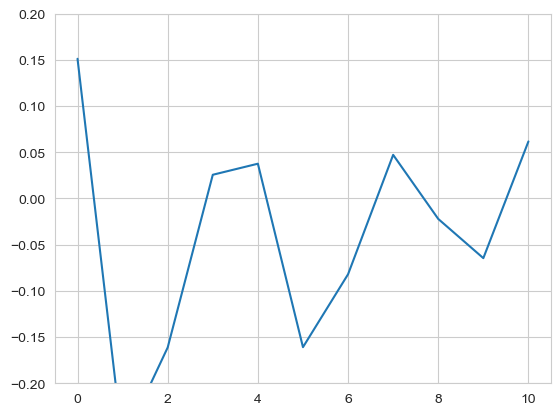

z_32_y_1569_x_661 143.0


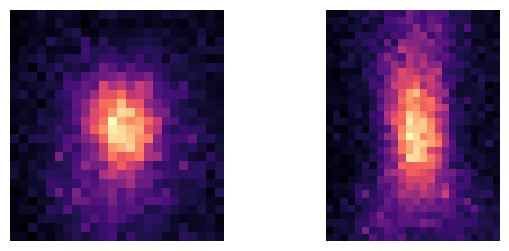

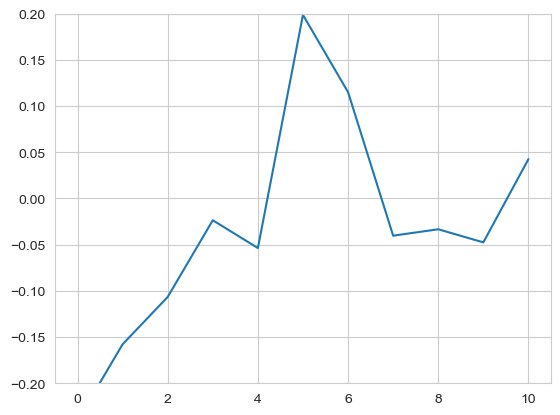

z_32_y_1588_x_1275 178.0


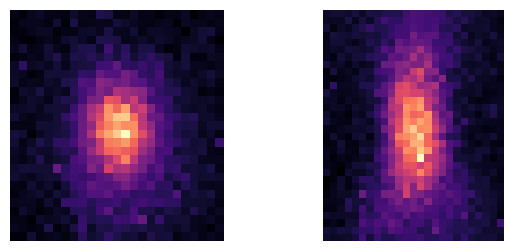

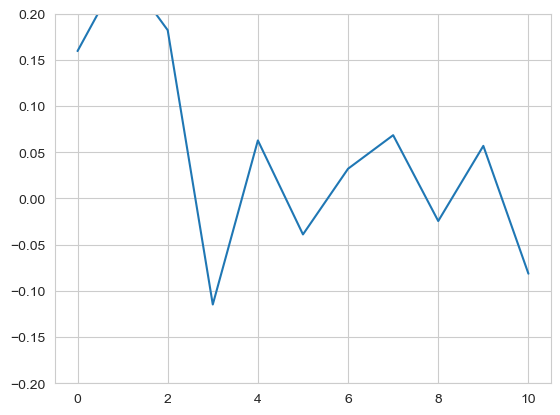

z_32_y_1758_x_841 132.0


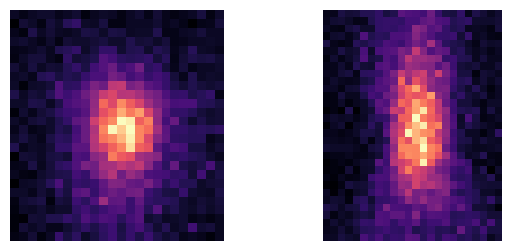

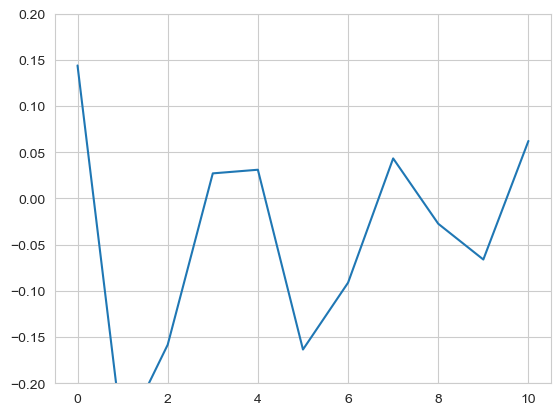

z_32_y_701_x_1581 183.0


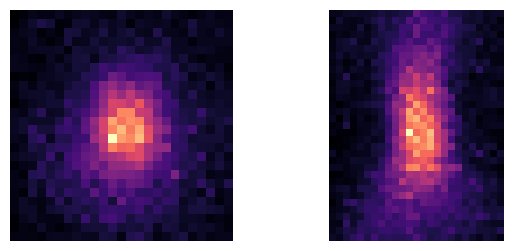

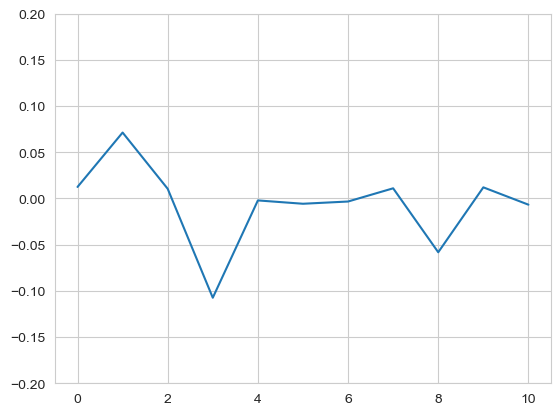

z_33_y_130_x_1591 116.0


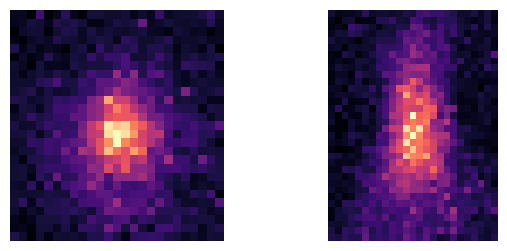

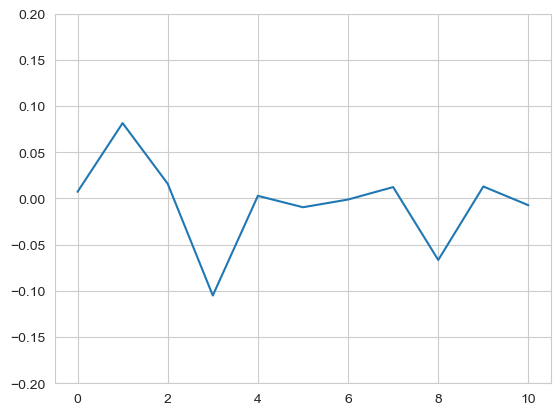

z_34_y_1151_x_742 169.0


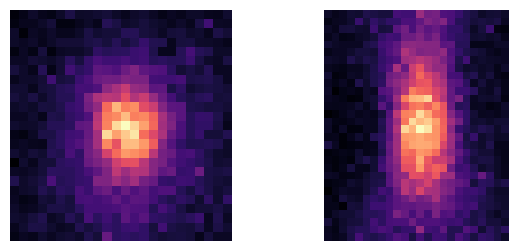

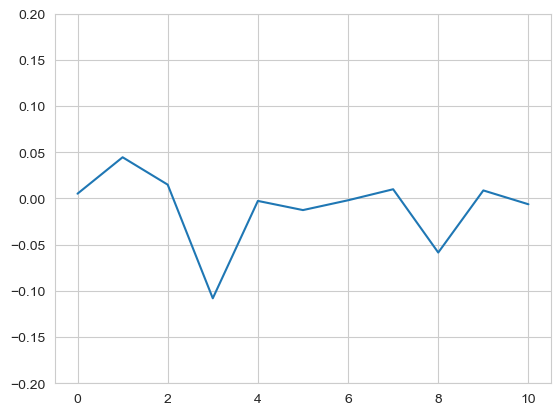

z_36_y_971_x_809 161.0


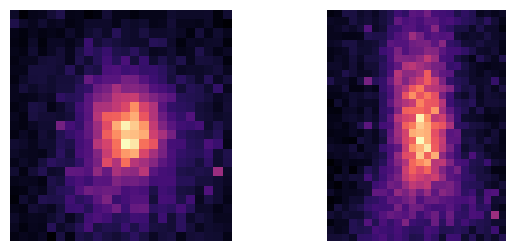

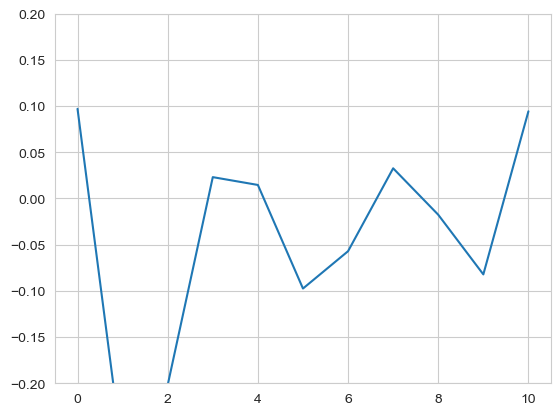

z_37_y_398_x_706 145.0


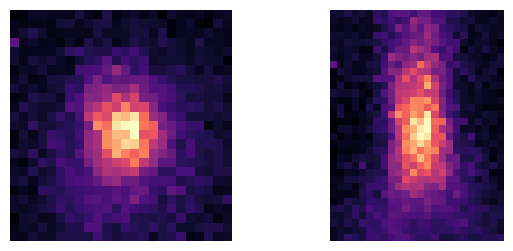

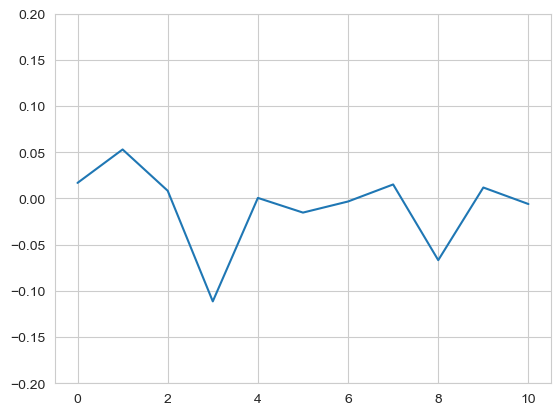

z_38_y_425_x_148 155.0


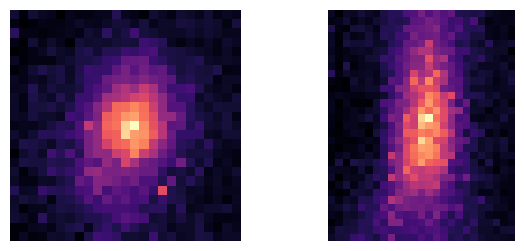

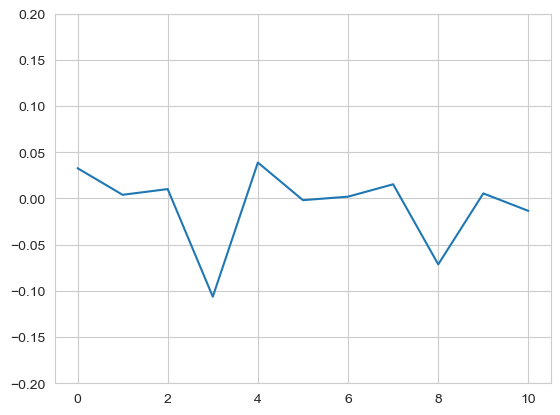

z_42_y_224_x_85 134.0


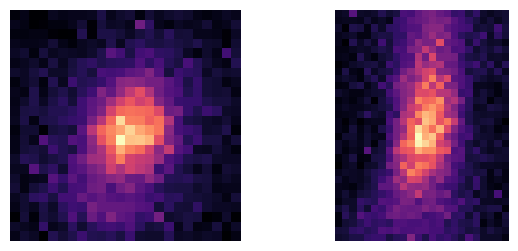

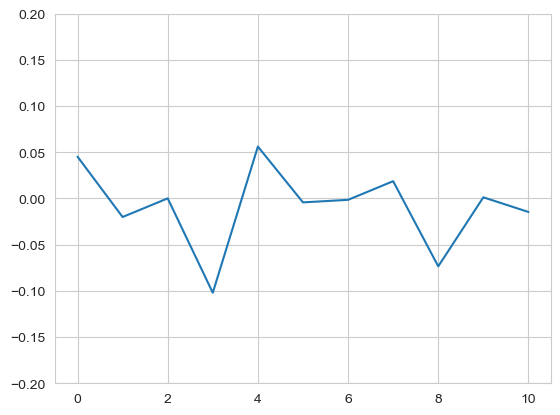

z_42_y_401_x_171 132.0


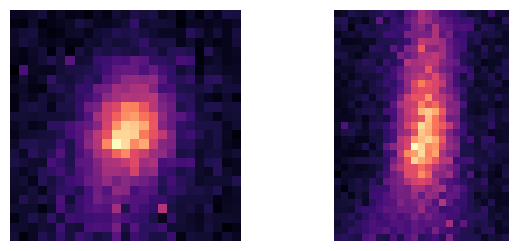

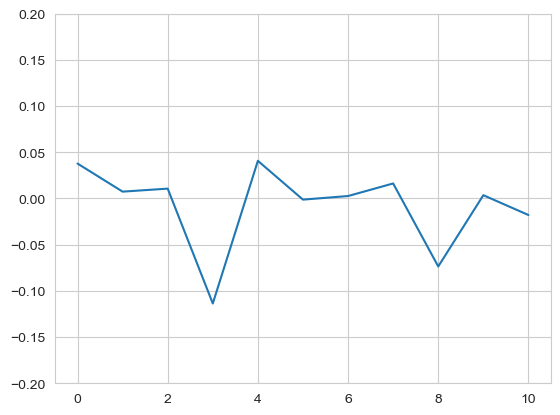

In [26]:
count = 0
for key,val in crops.items():
    count = count + 1
    print(key, np.max(val) - np.median(val))
    axs = show_patch(val)
    plt.plot(zola_full[key].values())
    plt.ylim(-0.2,0.2)
    plt.show()
    if count>50:
        break

# Plot the distribution

In [27]:
vals = np.array([list(z.values()) for z in zola_full.values()])
colum_name = ['astig_x','astig_y', 'vert_y', 'coma_y', 'coma_x', 'trefoil_x', 'quadrafoil_x', 'sec_astig_x', 'spherical', 'sec_astig_y', 'quadrafoil_y']
p1 = pd.DataFrame(data=vals, columns=colum_name)
df_c = pd.melt(p1)

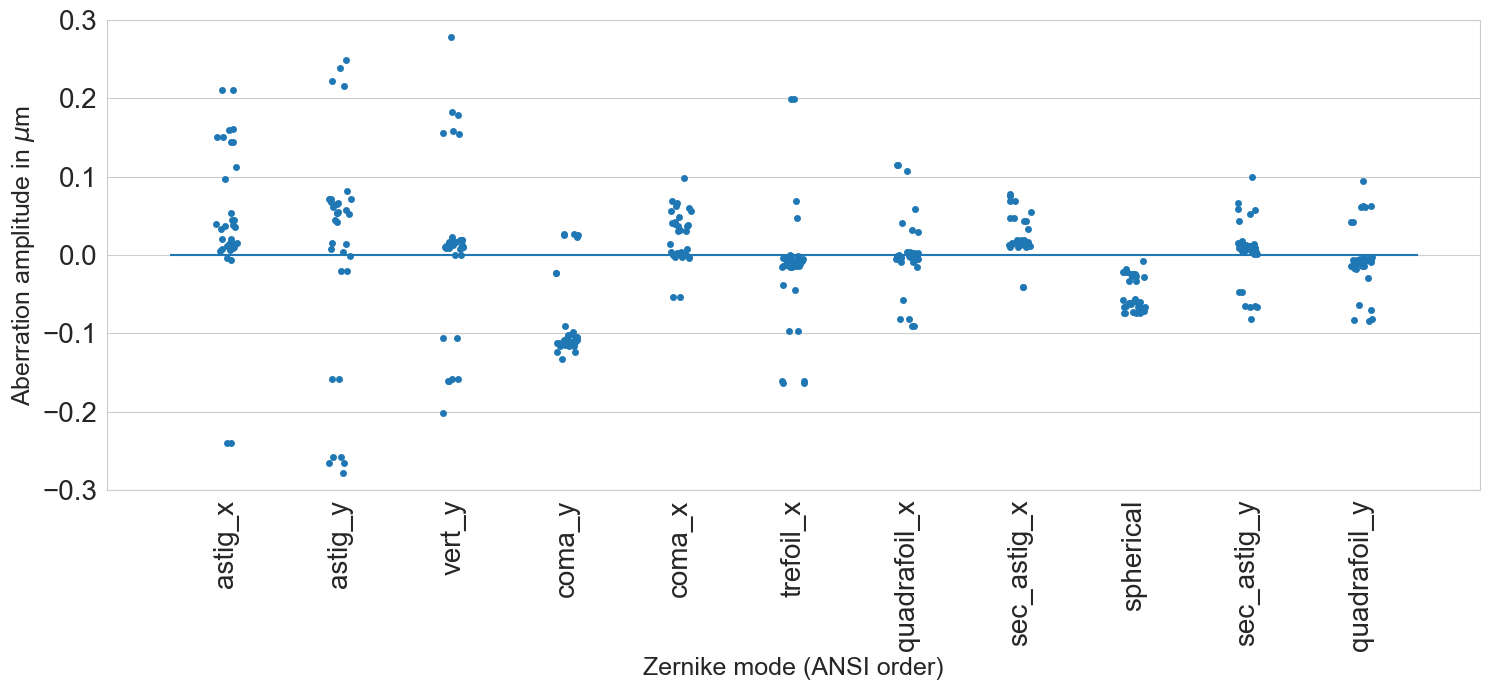

In [28]:
# plt.style.use('dark_background')
fig,axes = plt.subplots(1,1,figsize=(15,7))
# g = sns.violinplot(data =df_c, x='variable',y='value', inner='quartile');
# g = sns.swarmplot(data =df_c, x='variable',y='value');
g = sns.stripplot(data =df_c, x='variable',y='value');
plt.xticks(rotation=90, size=20)
plt.hlines(xmax=10.5, xmin=-0.5, y=0)
plt.xlabel("Zernike mode (ANSI order)", size=18)
plt.ylabel("Aberration amplitude in $\\mu$m",size=18)
plt.ylim(-0.3,0.3)
plt.yticks(size=20)
plt.tight_layout()
plt.show()
fig.savefig(f"{local_save_dir}/amplitude_distribution.png", transparent=True)

# Widths

In [29]:
fwhm = get_xyz_widths(crops, unit=unit, headless=True)
print(f"Could measure {len(fwhm)} widths")

Could measure 17 widths


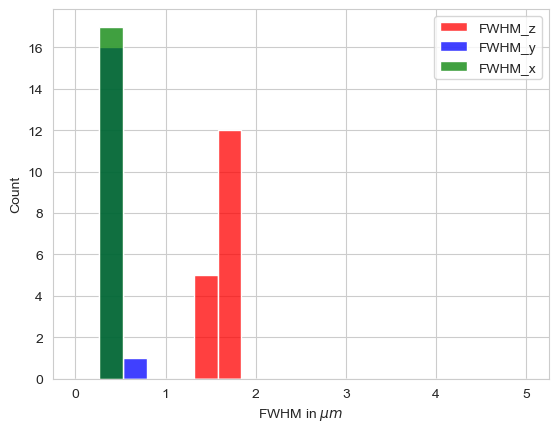

In [30]:
# plot the histogram of widths
arr = np.array(list(fwhm.values()))
max_bin=5
n_bins = 20
bins = np.linspace(0,max_bin,n_bins);
colors = ('r','b','g')
names = ('FWHM_z','FWHM_y','FWHM_x')
for i,(a,c) in enumerate(zip(arr.T, colors)):
    sns.histplot(data=np.clip(a,bins[0], bins[-1]), bins=bins,kde=False, color=c, label=names[i]);
plt.legend() ;
plt.xlabel(r"FWHM in $\mu m$");
# plt.xlim(0.2,)
plt.savefig(f"{local_save_dir}/selected_widths.png")
np.save(f"{local_save_dir}/selected_widths.npy", arr)

# Aberration maps

In [31]:
local_img_path

'/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test3/0p5mk.tif'

No masked image found
Accepted points


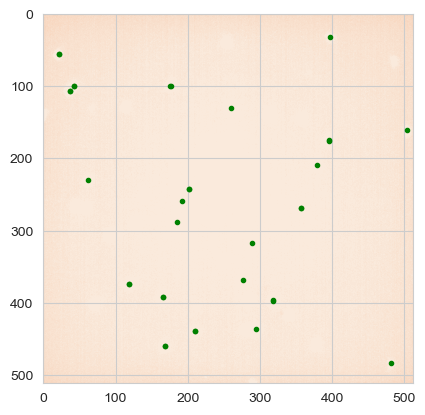

labeled_image:


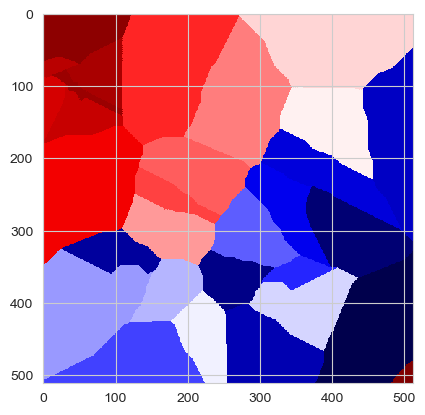

maxi_image:


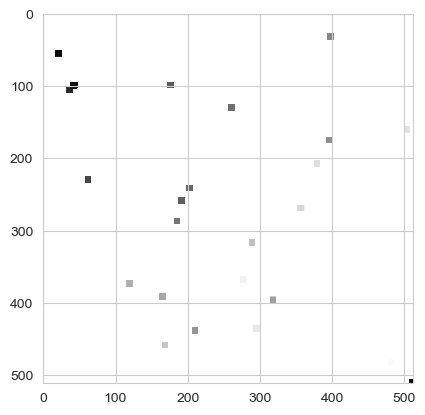

touch matrix


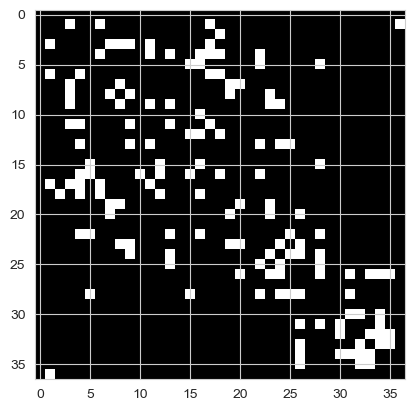

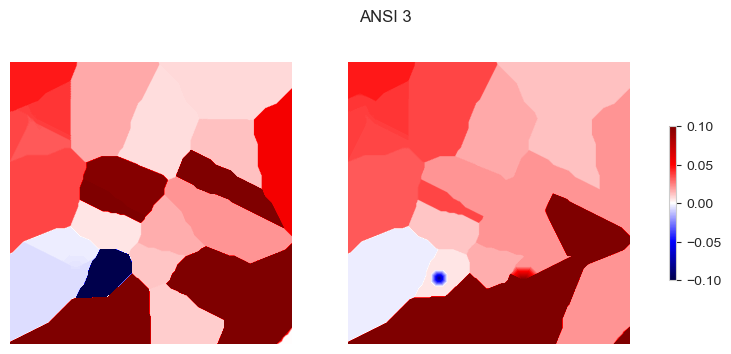

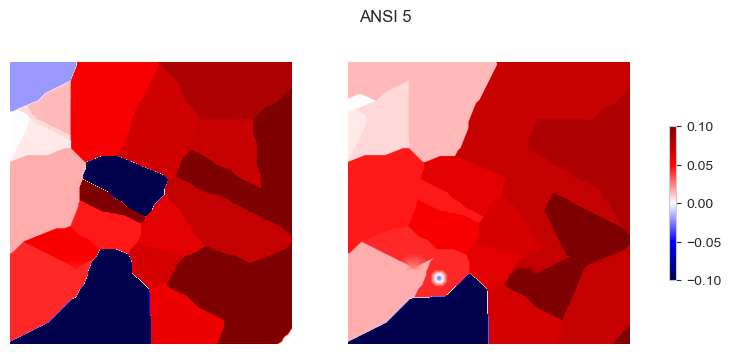

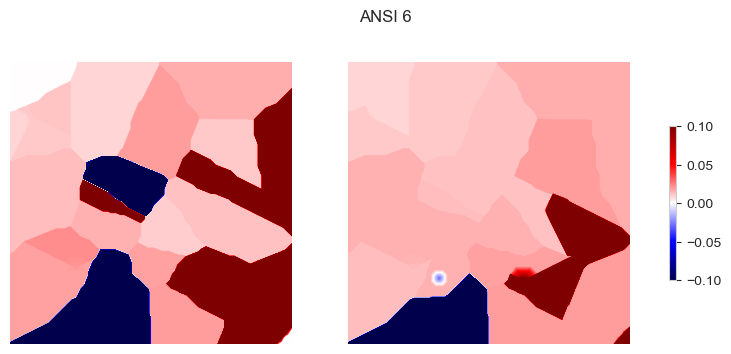

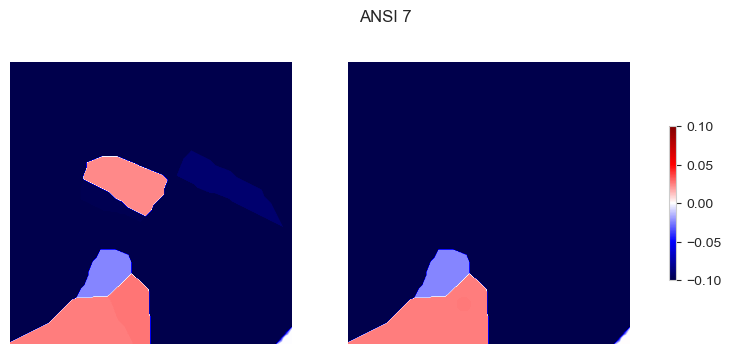

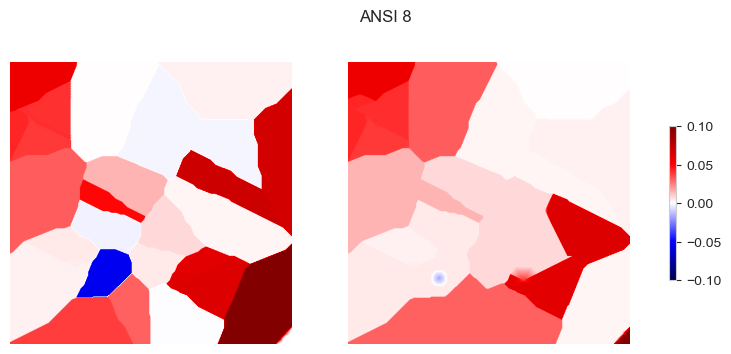

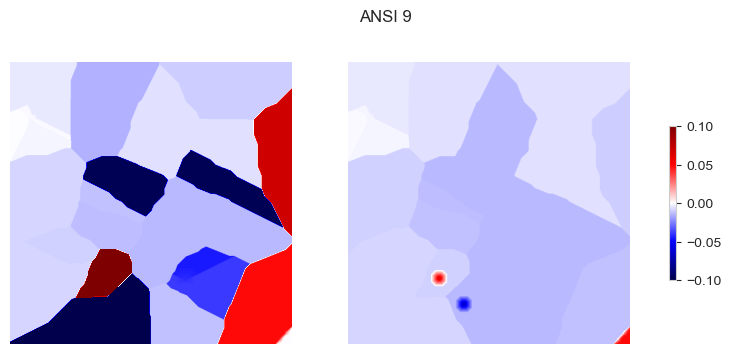

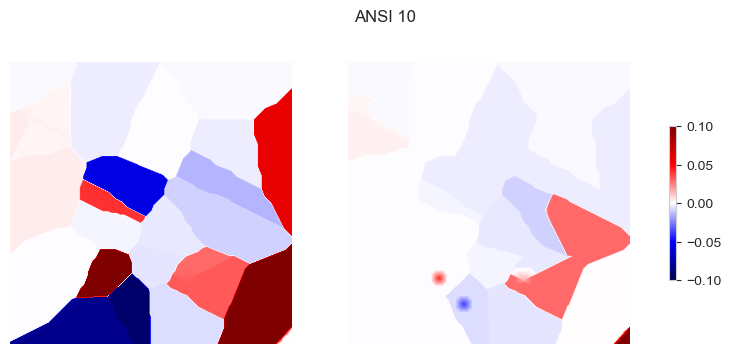

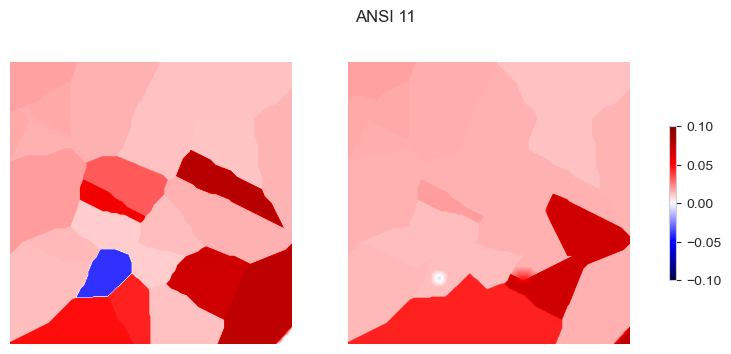

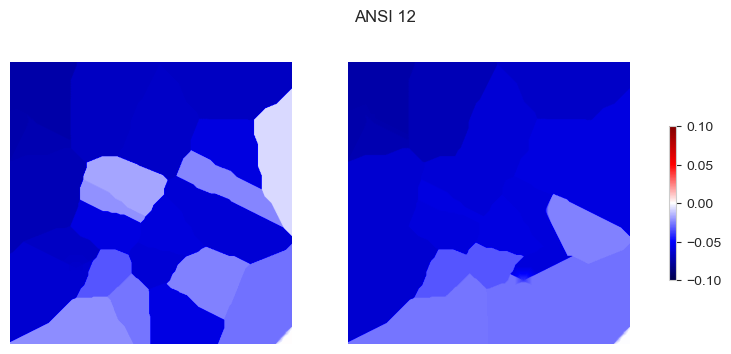

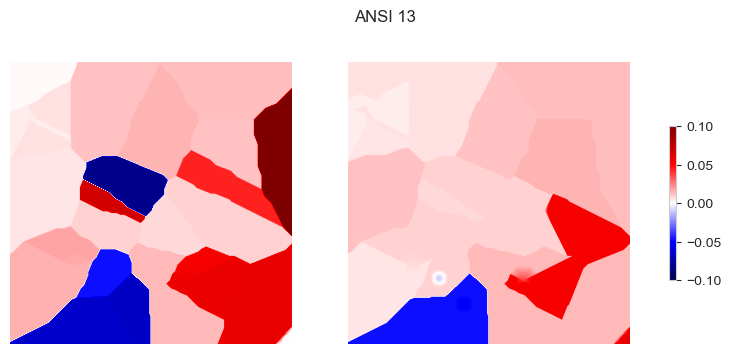

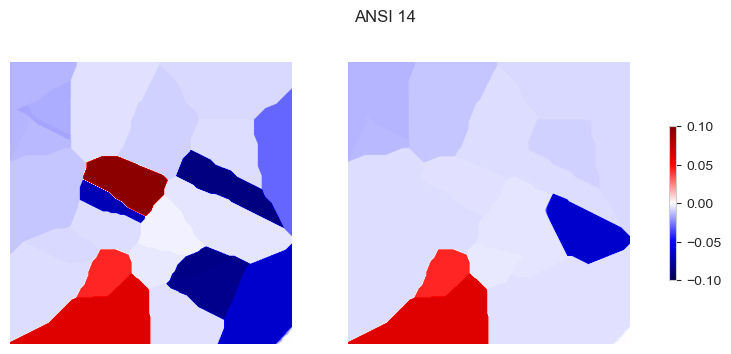

In [32]:
from main import create_abb_map
create_abb_map(
        local_img_path, 
        zola_full, 
        scale_factor=(4,)*3
)

# RMSWE

In [33]:
local_save_dir

'/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test3/'

In [34]:
! ls "{local_save_dir}"

0p5mk.tif                    med_measurement
Parameters.json              patches_for_zola
Results.csv                  point_boxes
abb_maps                     pointlist.npy
accepted_points_in_image.png points
amplitude_distribution.png   rmswe
label_map.tif                selected_widths.npy
measurements                 selected_widths.png


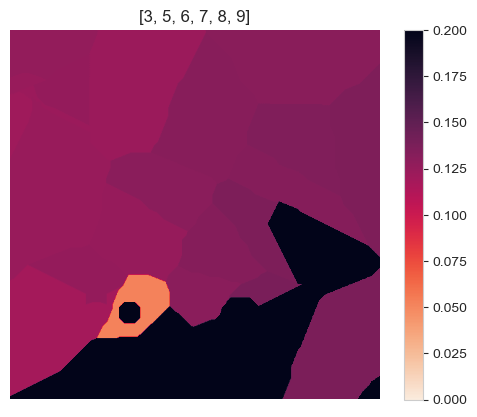

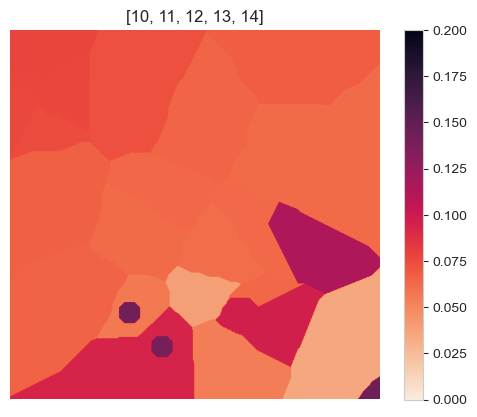

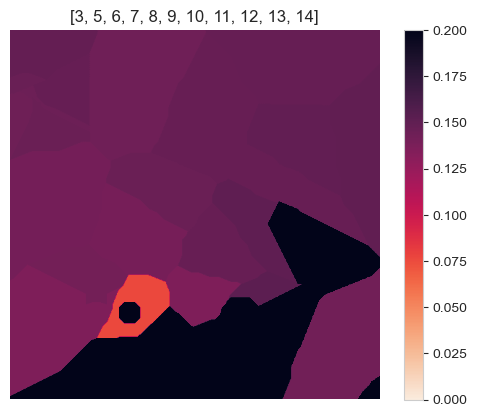

In [35]:
find_rmswe(local_save_dir)